# Sequências - Aula Prática 02/04
## RNNs (Recurrent Neural Networks)

Neste notebook iremos continuar nossos estudos de redes neurais recorrentes (RNNs), trabalhando dessa vez com geração de nomes a nível de caractere, utilizando os mesmos dados do notebook `name_classification.ipynb`.

> Em mais detalhes, dado um *idioma*, queremos construir uma rede (*language model*) para gerar um *nome* que possui características dos nomes originários daquele idioma.

- Esse notebook foi fortemente inspirado no segundo tutorial da série [NLP From Scratch](https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html), disponibilizado no site do PyTorch.

## Importação de pacotes

In [5]:
import torch
import random
import unicodedata

import numpy as np
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

from glob import glob
from tqdm.notebook import tqdm
from collections import defaultdict

In [6]:
# Verificando se temos CUDA disponível e selecionando o device que será utilizado
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device escolhido:', device)

Device escolhido: cuda


## Processamento da base de dados

Como mencionado no ínicio do notebook, iremos trabalhar com os mesmos dados vistos no notebook `name_classification.ipynb`. Porém, dessa vez, iremos trocar o que será entrada e saída do nosso modelo. No notebook anterior, tinhamos como entrada um nome (sequência) e como saída um idioma. Dessa vez, queremos admitir como entrada um idioma e *gerar* uma nome letra por letra.

Durante esse notebook, iremos trabalhar com os dados localizados na pasta `../data/names/`. Nela, você verá 18 arquivos `.txt` separados por países, onde cada arquivo contém uma lista de nomes originários daquele país.

> Para esse notebook, iremos processar os dados de maneira similar, criando um dicionário que mapeia `linguagem -> lista de nomes` e também definindo a função `unicode2ascii` para remover caracteres especiais de idiomas específicos.

In [7]:
filepaths = glob('../data/names/*.txt')  # * aqui quer dizer "qualquer string"
filepaths

['../data/names/Arabic.txt',
 '../data/names/Chinese.txt',
 '../data/names/Czech.txt',
 '../data/names/Dutch.txt',
 '../data/names/English.txt',
 '../data/names/French.txt',
 '../data/names/German.txt',
 '../data/names/Greek.txt',
 '../data/names/Irish.txt',
 '../data/names/Italian.txt',
 '../data/names/Japanese.txt',
 '../data/names/Korean.txt',
 '../data/names/Polish.txt',
 '../data/names/Portuguese.txt',
 '../data/names/Russian.txt',
 '../data/names/Scottish.txt',
 '../data/names/Spanish.txt',
 '../data/names/Vietnamese.txt']

In [8]:
def get_language(filepath):
    filename = filepath.split('/')[-1]
    language = filename.split('.')[0]

    return language

print('Primeiro filepath:', filepaths[0])
print('Linguagem do primeiro filepath:', get_language(filepaths[0]))

Primeiro filepath: ../data/names/Arabic.txt
Linguagem do primeiro filepath: Arabic


In [9]:
languages = [] 
language_names = defaultdict(list)

for filepath in filepaths:
    language = get_language(filepath)
    languages.append(language)
    
    with open(filepath, 'r') as fp:
        lines = fp.readlines()

        for line in lines:
            line = line.strip()
            language_names[language].append(line)

print('5 primeiros nomes em árabe:', language_names['Arabic'][:5])
print('Línguas disponíveis no conjunto de dados:', languages)

5 primeiros nomes em árabe: ['Khoury', 'Nahas', 'Daher', 'Gerges', 'Nazari']
Línguas disponíveis no conjunto de dados: ['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']


Aqui definimos a função `unicode2ascii`, exemplificando com o nome Como estamos trabalhando com palavras de linguagens que possuem caracteres especiais em seus nomes, como por exemplo: `Ślusàrski`.

In [10]:
all_letters = set()

for names in language_names.values():
    for name in names:
        for letter in name:
            all_letters.add(letter)

print(f'Temos {len(all_letters)} letras distintas na nossa base de dados')

Temos 82 letras distintas na nossa base de dados


In [11]:
def unicode2ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print('Conversão do nome Ślusàrski para ASCII:', unicode2ascii('Ślusàrski'))

Conversão do nome Ślusàrski para ASCII: Slusarski


Seguindo as ideias trabalhadas em notebooks passados, precisamos criar um mapeamento entre *tokens* e índices. No nosso caso, o *token* é uma letra do nosso alfabeto. Para isso, iremos construir nosso alfabeto (vocabulário), com base nas letras únicas de todos os nomes da base de dados, e, posteriormente, iremos criar 2 estruturas para realizar tal mapeamento: `letter2index` e `index2letter`.

> Além dos *tokens* obtidos através do texto, é muito comum vermos também outros 3 *tokens* especiais:
> - **\<sos\>**: abreviação para *start-of-sequence*, ou início de sentença.
> - **\<eos\>**: abreviação para *end-of-sequence*, ou fim de sentença.
> - **\<pad\>**: *token* especial destinado para indicar um valor de *pad* na nossa sequência.

- Diferentemente do notebook anterior, os *tokens* de **\<sos\>** e **\<eos\>** serão úteis, uma vez que eles são utilizados em contextos de geração de sentenças. O token **\<pad\>** ainda não será utilizado, uma vez que ainda não trabalharemos com *batches* por enquanto.

In [12]:
vocabulary = []

# Adicionando os tokens especiais <sos> e <eos>
vocabulary.append('<sos>')
vocabulary.append('<eos>')

for letter in all_letters:
    letter = unicode2ascii(letter)
    if letter not in vocabulary:
        vocabulary.append(letter)

print('Tamanho do alfabeto:', len(vocabulary))
print('5 tokens aleatórios do alfabeto:', random.choices(vocabulary, k=5))

Tamanho do alfabeto: 59
5 tokens aleatórios do alfabeto: ["'", 'E', 'V', 'R', 'E']


In [13]:
index2letter = []
letter2index = {}

for token_idx, token in enumerate(vocabulary):
    index2letter.append(token)
    letter2index[token] = token_idx

print('Token de índice 42:', index2letter[42])
print('Índice do token "<sos>":', letter2index['<sos>'])
print('Índice do token "<eos>":', letter2index['<eos>'])

Token de índice 42: p
Índice do token "<sos>": 0
Índice do token "<eos>": 1


Agora que temos as estruturas `index2letter` e `letter2index` bem definidas, conseguimos converter um nome em um tensor de índices numéricos através da função `name2tensor`, como demonstrado a seguir.

> **Observação 1:** Criaremos um tensor de tamanho $n \times 1$, onde $n$ é o tamanho do nome e $1$ o tamanho do nosso *batch*. Para esse notebook, nós não iremos trabalhar com `batch_size > 1`, devido à complicações relacionadas com manipulação de sequências e *padding*. Deixaremos tais assuntos para serem abordados no notebook de `seq2seq`.
>
> **Observação 2:** Como estamos trabalhando com geração de sequências, iremos também colocar na codificação do nome os token de começo de sentença (`<sos>`) e fim de sentença (`<eos>`).

- Optamos por trocar a ordem padrão das dimensões dos dados em PyTorch, ou seja, com o tamanho do *batch* no começo, para facilitar operações em sequências no futuro, como utilizar `len` para obter o tamanho da sequência e tornar a indexação mais fácil. Na verdade, especificamente para sequências, PyTorch nos dá a opção de colocar o tamanho do *batch* como primeira dimensão do nosso tensor ou na segunda, sendo a primeira o tamanho da nossa sequência. Veremos isso em mais detalhes quando trabalharmos com os modelos recorrentes implementados pelo PyTorch.

In [14]:
def name2tensor(name):
    tensor = torch.zeros((2 + len(name), 1), dtype=torch.long)
    
    # Adicionando os tokens de início e fim de sentença
    tensor[0] = letter2index['<sos>']
    tensor[-1] = letter2index['<eos>']
    
    for idx, letter in enumerate(name):
        tensor[idx+1] = letter2index[letter]

    return tensor

name = 'Jonas'
print(f'Tensor para o nome {name}: {name2tensor(name).T}')  # transposição para fins de print

Tensor para o nome Jonas: tensor([[ 0, 40,  6, 13,  9, 56,  1]])


Para finalizar essa parte do notebook sobre dados, iremos criar uma função auxiliar `get_random_pair` para selecionar de forma aleatória um par `(idioma, nome)` da nossa base dados. Além disso, tal função irá retornar os tensores relacionados com cada componente do par.

- Por ora não iremos nos preocupar com a separação entre conjuntos de treino, validação e teste. O objetivo desse notebook é de ensinar como trabalhamos do zero com geração de sequências.

In [27]:
def language2tensor(language):
    return torch.tensor([languages.index(language)], dtype=torch.long)

def get_random_pair():
    language = random.choice(languages)
    name = random.choice(language_names[language])

    name = unicode2ascii(name)
    name_tensor = name2tensor(name)
    language_tensor = language2tensor(language)

    return name, language, name_tensor, language_tensor

In [28]:
name, language, name_tensor, language_tensor = get_random_pair()

print('Par selecionado:', (name, language))
print('Tensores do par:', (name_tensor.T, language_tensor))

Par selecionado: ('Campana', 'Italian')
Tensor do nome: (tensor([[ 0, 22,  9,  8, 42,  9, 13,  9,  1]]), tensor([9]))


## Definição do nosso modelo

Como já tratamos a implementação de uma RNN do zero no notebook anterior, iremos utilizar o módulo `nn.RNN` disponibilizado pelo PyTorch. Uma documentação mais extensiva desse módulo pode ser encontrada [aqui](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#rnn). Não iremos utilizar todos os parâmetros customizáveis do módulo, mas iremos explicar eles aqui brevemente.

- **`input_size`**: o número de *features* da entrada, no nosso caso por exemplo o tamanho da dimensão de *embedding*.
- **`hidden_size`**: o tamanho do estado oculto ($h$) que utilizaremos.
- **`num_layers`**: número de camadas recorrentes que iremos "empilhar".
- **`nonlinearity`**: a camada de ativação não linear utilizado ao longo da recorrência.
- **`bias`**: valor *booleano* indicando se queremos ou não utilizar viés nas camadas.
- **`batch_first`**: valor *booleano* que permite a gente indicar se queremos trabalhar com dados onde a primeira dimensão é o tamanho do *batch*, nesse caso `batch_first=True`, ou o tamanho da sequência.
- **`dropout`**: introduz *dropout* em cada saída da camada recorrente (usado com `num_layers != 1`).
- **`bidirectional`**: valor *booleano* que indica se queremos um modelo recorrente bidirecional.

Logo abaixo temos um exemplo de utilização do módulo `nn.RNN`. Suponha que após aplicarmos o embedding, nós tenhamos a matriz `X`, cujas dimensões são: $S \times 1 \times E$, onde $S$ é o tamanho da sequência e $E$ o tamanho do embedding escolhido.

> Para esse exemplo utilizamos: $S = 4$, $E = 2$, $h = 8$.

In [17]:
seq_length = 4
embedding_size = 2
X = torch.rand(seq_length, 1, embedding_size)  # definindo uma matriz X aleatória apenas para exemplo

hidden_size = 8
model = nn.RNN(embedding_size, hidden_size, batch_first=False)

hidden = None  # nn.RNN irá selecionar h0 como sendo zeros
for Xt in X:
    outputs, hidden = model(Xt, hidden)

print('Tamanho do output final:', outputs.shape)
print('Tamanho do hidden final:', hidden.shape)

Tamanho do output final: torch.Size([1, 8])
Tamanho do hidden final: torch.Size([1, 8])


Como iremos trabalhar com geração de texto, **condicionando** a geração de nomes a partir de um idioma específico, a entrada do nosso modelo no tempo $t$ será a concatenação do *embedding* do *token* atual com o do idioma selecionado. Para isso, teremos dois *embeddings* diferentes: um para a transformação do idioma; e outro para transformação do *token*.

Um diagrama do esquema de geração pode ser visto a seguir, note que a nossa arquitetura possui uma modelagem autorregressiva, ou seja, a predição do tempo o $t$ depende das predições do tempo $t-1$, e assim por diante. Nele, o símbolo `&` representa o operador de concatenação das entradas.

> A geração da sentença será finalizada quando o modelo prever um *token* de fim de sentença ou quando atingirmos um tamanho predeterminado, forçando assim a adição de um `<eos>` no final da predição.

![](../imagens/rnn_autorregressivo.png)

In [36]:
class NameGenerationModel(nn.Module):
    def __init__(self, vocab_size, num_languages, embedding_size, hidden_size):
        super().__init__()

        self.letter_embedding = nn.Embedding(vocab_size, embedding_size)
        self.language_embedding = nn.Embedding(num_languages, embedding_size)

        self.rnn = nn.RNN(2 * embedding_size, hidden_size, batch_first=False)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, vocab_size),
            nn.LogSoftmax(dim=-1)
        )

    def forward(self, x, language, hidden = None):
        x = self.letter_embedding(x)
        language = self.language_embedding(language)
        combined = torch.cat([x, language], dim=-1)  # iremos concatenar ao longo das features

        output, hidden = self.rnn(combined, hidden)
        output = self.classifier(output)

        return output, hidden

Exemplo da utilização da rede para o tempo $t = 0$.

In [43]:
token = '<sos>'
language = 'Portuguese'

token_tensor = torch.tensor([letter2index[token]], dtype=torch.long)
language_tensor = language2tensor(language)

model = NameGenerationModel(len(vocabulary), len(languages), embedding_size=16, hidden_size=32)
output, hidden = model(token_tensor, language_tensor)

print('Saída do modelo:', output)
print('\nEstado oculto:', hidden)

next_token = output.argmax()
print('\nPróximo token previsto:', index2letter[next_token])

Saída do modelo: tensor([[-4.5177, -4.2016, -4.4384, -4.0774, -3.9993, -4.0990, -4.2623, -4.1629,
         -3.7792, -4.0087, -4.1394, -4.2523, -4.3361, -4.3041, -4.3803, -4.1024,
         -3.9614, -4.7927, -4.1533, -4.0049, -4.6599, -4.2513, -3.9758, -4.1205,
         -3.6877, -4.1299, -4.1055, -3.9044, -3.7228, -3.7072, -3.9234, -3.9629,
         -4.1653, -3.6023, -4.1496, -4.0048, -4.2429, -3.7834, -4.6581, -3.9871,
         -4.3556, -4.0841, -4.4248, -4.1736, -3.7773, -3.8366, -3.9824, -4.5761,
         -4.0504, -3.6743, -4.1786, -4.2883, -4.0161, -4.0216, -3.6937, -3.7759,
         -4.5024, -4.0940, -4.3389]], grad_fn=<LogSoftmaxBackward0>)

Estado oculto: tensor([[-0.2875,  0.5623, -0.2972,  0.3262,  0.4688, -0.3858,  0.2979, -0.3852,
         -0.6292,  0.7268,  0.5689,  0.7798,  0.3796, -0.1676,  0.6587, -0.1224,
         -0.8674,  0.5500, -0.8282,  0.6255, -0.7207,  0.5174,  0.2675, -0.2863,
          0.5848,  0.2805, -0.4488, -0.2006,  0.5284,  0.4336,  0.3547, -0.7055]],
     

## Treinamento do modelo

Para o treinamento do modelo generativo, iremos introduzir um novo conceito conhecido como *teacher forcing*, uma estratégia de treinamento de geração de sequências para acelerar a convergência do modelo e garantir estabilidade ao longo do treinamento. A estratégia consiste em utilizar como entrada para o tempo $t$ o *token* real do tempo $t-1$ ao invés da predição do modelo.

À primeira vista, essa estratégia pode parecer "roubada". Porém, temos que lembrar que o predição do modelo no tempo $t$ é dada pelo *ground truth* do tempo $t-1$ e o estado oculto do modelo que foi atualizado utilizando os *ground truths* do tempo $1$ até $t-2$. Ou seja, o modelo ainda está aprendendo os padrões linguísticos da sentença que lhe foi apresentada, mesmo não usando as suas próprias predições. Uma analogia interessante que podemos fazer com *teacher forcing* é quando vamos fazer uma prova onde a questão **d)** depende da resposta correta da questão **c)** e assim por diante. Se errarmos a questão **a)**, estaremos correndo o risco de errar todas as questões seguintes, mesmo realizando os cálculos corretos. Porém, se no começo de cada questão nós começarmos com a resposta correta da anterior, conseguimos acertar algumas coisas.

> **Importante:** Durante a geração de sentenças fora do treino, utilizaremos as predições do modelo ao invés do *ground truth* da sentença, uma vez que tal informação não está disponível. Sendo assim, é esperado observar uma discrepância da performance do modelo. Isso é conhecido na literatura como *exposure bias*, e uma forma simples de mitigar esse efeito é de utilizar *teacher forcing* de maneira probabilística, reduzindo a probabilidade de uso a medida que o modelo prevê novos *tokens* da sentença. Outra estratégia interessante pode ser lida no seguinte [artigo](https://arxiv.org/pdf/2103.11603.pdf), onde os autores propõem fornecer para o modelo um conjunto de palavras similares preditas no passo $t-1$ ao invés de um único *ground truth*.

- Apenas para relembrar: Como o nosso modelo recorrente possui como última camada uma `LogSoftmax`, iremos utilizar a função de perda `nn.NLLLoss` (*negative log-likelihood*), que espera log-probabilidades como saída da rede. Um fato curioso é que `nn.CrossEntropyLoss = LogSoftmax + nn.NLLLoss`, segundo a própria [documentação](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) da `nn.CrossEntropyLoss`.

In [45]:
model = NameGenerationModel(len(vocabulary), len(languages), embedding_size=64, hidden_size=128)
model = model.to(device)

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

loss_interval = 1000  # intervalo para salvar a loss média
print_interval = 5000  # intervalo para exibir performance da rede
num_iterations = 100000

# Variáveis para manter o valor da loss ao longo das épocas
all_losses = []
average_loss = 0

Algo a se notar aqui é que ao invés de usarmos a última saída da rede para calcular a função de custo, como no caso da classificação de nomes, estaremos realizando uma predição a cada instante de tempo. Logo, precisaremos calcular a função de custo para cada predição.

Para lidar com isso, o `autograd` do PyTorch permite você apenas somar todos os valores das funções de custo em cada instante de tempo e depois chamar `.backward()` no fim.

In [47]:
for iter in tqdm(range(1, num_iterations + 1)):
    name, language, name_tensor, language_tensor = get_random_pair()
    
    name_tensor = name_tensor.to(device)
    language_tensor = language_tensor.to(device)

    loss = 0
    hidden = None
    predicted_name = ''

    # Iremos iterar sobre todos os tokens até o penúltimo
    for idx in range(len(name_tensor) - 1):
        output, hidden = model.forward(name_tensor[idx], language_tensor, hidden)  # note que estamos sempre fazendo teacher forcing
        loss += criterion(output, name_tensor[idx+1])

        # Salvando o nome predito pelo modelo
        letter = index2letter[output.argmax()]
        if letter != '<eos>':
            predicted_name += letter
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    average_loss +=  loss.item() / (len(name_tensor) - 1)
    
    if iter % print_interval == 0:
        print(f'Iter [{iter}/{num_iterations}] => loss: {loss:.5f}, ' \
              f'input: {language, name}, predicted name: {predicted_name}')

    if iter % loss_interval == 0:
        all_losses.append(average_loss / loss_interval)
        average_loss = 0

  0%|          | 0/100000 [00:00<?, ?it/s]

Iter [5000/100000] => loss: 12.69394, input: (('Spanish', 'Puga')), predicted name: Aarar
Iter [10000/100000] => loss: 7.56679, input: (('Korean', 'Yeon')), predicted name: Yoo<eos><eos>
Iter [15000/100000] => loss: 16.74781, input: (('Italian', 'Gaspari')), predicted name: Aarti<eos>i<eos>
Iter [20000/100000] => loss: 18.38812, input: (('Italian', 'De felice')), predicted name: Ae pellni<eos>
Iter [25000/100000] => loss: 5.44092, input: (('Vietnamese', 'Lieu')), predicted name: Tueu<eos>
Iter [30000/100000] => loss: 5.45188, input: (('Chinese', 'Feng')), predicted name: Leng<eos>
Iter [35000/100000] => loss: 15.61737, input: (('Spanish', 'Santiago')), predicted name: Vanten<eos><eos><eos>


KeyboardInterrupt: 

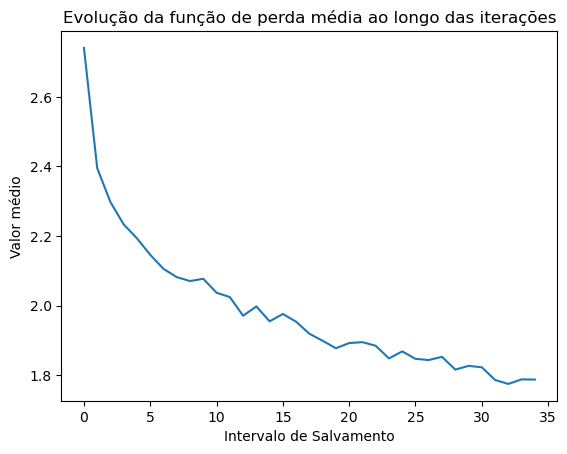

In [51]:
plt.title('Evolução da função de perda média ao longo das iterações')
plt.xlabel('Intervalo de Salvamento')
plt.ylabel('Valor médio')
    
plt.plot(all_losses)
plt.show()

## Avaliando os resultados obtidos

Para verificar o desempenho da rede em diferentes línguas, criaremos uma matriz de confusão, indicando para cada idioma real (linhas) qual idioma a rede adivinha (colunas). Para calcular a matriz de confusão, uma quantia grande de amostras, definida pela variável `num_confusion_samples`, serão processadas pela rede em modo de avaliação.

In [ ]:
num_confusion_samples = 10000
confusion_matrix = torch.zeros(len(languages), len(languages))

model.eval()
with torch.no_grad():
    for i in tqdm(range(num_confusion_samples)):
        name, language, name_tensor, language_tensor = get_random_pair()

        name_tensor = name_tensor.to(device)
        language_tensor = language_tensor.to(device)

        output = model(name_tensor)
        guess = get_language_from_output(output)

        guess_idx = languages.index(guess)
        language_idx = languages.index(language)

        confusion_matrix[language_idx, guess_idx] += 1

# Normalizando as linhas da matriz de confusão
for i in range(len(languages)):
    confusion_matrix[i] /= confusion_matrix[i].sum()

# Configurando o plot
fig, ax = plt.subplots()

img = ax.matshow(confusion_matrix.numpy())
fig.colorbar(img)

ax.set_xticks(range(len(languages)), languages, rotation=90)
ax.set_yticks(range(len(languages)), languages)

fig.tight_layout()

## Verificando as top 3 predições da rede

In [ ]:
def predict(name):
    print(f'\n> {name}')

    model.eval()
    with torch.no_grad():
        name_tensor = name2tensor(name).to(device)
        output = model(name_tensor)

        vals, idxs = torch.topk(output[0], k=3, dim=-1)
        for val, idx in zip(vals, idxs):
            prob = torch.e ** val  # probabilidade = exp(log-probabilidade)
            print(f'({prob:.2f}) {languages[idx]}')
            
predict('Dovesky')
predict('Jackson')
predict('Satoshi')